In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

In [2]:


dtype=torch.float
torch.manual_seed(734)
print("Feedforward SNN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True,drop_last=True)

Feedforward SNN Trained on MNIST
Using device: cuda


Use a connectivity percentage as it's easier to calculate\
given $\theta_k \leftarrow \theta_k - \eta \frac{\partial}{\partial \theta_k} \mathbb{E}_{X, Y^*}(\theta) - \eta \alpha + \sqrt{2\eta T} \nu_k$,\
$-\eta \frac{\partial}{\partial \theta_k} \mathbb{E}_{X, Y^*}(\theta)$ is already applied during the backward pass.\
Therefore in our training loop we need to apply $- \eta \alpha + \sqrt{2\eta T} \nu_k$ to connection weights.

Also we can combine the sign and mask matrix into one where we have each element either 1/-1 for the sign or 0 if inactive.

In [7]:
################ MNIST Model ##############################################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 200
num_hidden2 = 50
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3
#weight_decay=1e-6

spike_grad1 = surrogate.atan()

class WeightMasker(nn.Module):

    #TODO try sending tensors to CUDA

    def __init__(self, linearsList : nn.ModuleList, learnRate, temp = 0.05, alpha = 0.05, connectivity = 0.3 ):
        super().__init__()
        self.learnRate = learnRate
        self.regulariser = alpha * learnRate
        self.noiseTemp = temp
        self.connectivity = connectivity
        self.weightSignMasks = []

        #initialise with weight connectivity %
        for i in self.LinearsList:
            weightMask = ((torch.rand_like(i.weight))<self.connectivity) #do i need float()?
            i.weight = i.weight * weightMask #hadamard product
            self.weightSignMasks.append( torch.sign(i.weight) * weightMask )#TODO is masking i.weight within sign faster? /does it work? (i.weight[weightMask])

    def deepr_update(self):
        for i in zip(self.LinearsList,self.weightSignMasks):
            #update weights with rest of terms in update rule
            self.weightDiff = torch.randn_like(i[0].weight)*((2*self.learnRate*self.noiseTemp)**0.5) - self.regulariser
            i[0].weight = i[0].weight + self.weightDiff

            #remove connections below threshold
            remove_weights = i[0].weight >= 0

            #update mask
            i[1] = i[1] * remove_weights #would seperate sign and mask matricies be faster using masks and bitwise & instead?

            weightMask = torch.abs(i[1])

            #TODO you could probably write a CUDA kernel for this
            #remove weights
            i[0] = i[0] * weightMask #seperate mask would avoid abs

            ### Ensure there are enough active connections
            #TODO atm this isnt true to the paper, the connectivity is calculated GLOBALLY. i.e. some layers may be more sparse than others.
            #this is just easier to implement atm for testing
            i_numel = torch.numel(i[0])
            to_activate = int( (self.connectivity - (i_numel / weightMask.sum())) * i_numel )
            if to_activate>0:

                # Get the indices of the elements that are equal to zero
                zero_indices = torch.where(i[0]==0)[0] #why does torch.where return a tuple?

                # Randomly select n indices
                zero_ind_ind = torch.randperm(torch.numel(zero_indices))[:to_activate] #TODO inefficient
                # see https://stackoverflow.com/questions/59461811/random-choice-with-pytorch

                # Get the selected indices
                selected_weights = zero_indices[zero_ind_ind] #weight indicies

            #enable the weights selected
            
        

    def forward_pre_hook(self,module,args):
        pass

    def back_hook(self,module,grad_input,grad_output):
        pass

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1,num_hidden2),
            nn.Linear(num_hidden2,num_outputs)
        ])

        self.weightMasker = WeightMasker(self.linears,lr)

        # initialize neurons
        self.neurons = nn.ModuleList([
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1)
        ])

        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data

        #spike encoding at input layer
        x_spk = spikegen.rate(x,num_steps=num_steps) 
        # Initialize hidden states
        
        mem1 = self.neurons[0].init_leaky()
        mem2 = self.neurons[1].init_leaky()
        mem3 = self.neurons[2].init_leaky()
        
        mems = []
        for n in self.neurons:
            mems.append(n.init_leaky())

        # record spike outputs and membrane potentials
        mem3_rec = []
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input

            cur1 = self.linears[0](x)
            spk1, mem1 = self.neurons[0](cur1, mem1)

            cur2 = self.linears[1](spk1)
            spk2, mem2 = self.neurons[1](cur2, mem2)

            cur3 = self.linears[2](spk2)
            spk3, mem3 = self.neurons[2](cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)
    
###################################################################################



IndentationError: expected an indented block after 'for' statement on line 30 (2181349819.py, line 34)

Epoch 0, Iteration 0, Minibatch stats:
    Train Set Loss: 2.79
    Test Set Loss: 6.41
    Accuracy: 11.72%
    Accuracy: 8.59%


Epoch 0, Iteration 50, Minibatch stats:
    Train Set Loss: 0.47
    Test Set Loss: 0.33
    Accuracy: 86.72%
    Accuracy: 90.62%


Epoch 0, Iteration 100, Minibatch stats:
    Train Set Loss: 0.27
    Test Set Loss: 0.28
    Accuracy: 92.19%
    Accuracy: 90.23%


Epoch 0, Iteration 150, Minibatch stats:
    Train Set Loss: 0.24
    Test Set Loss: 0.20
    Accuracy: 94.92%
    Accuracy: 93.75%


Epoch 0, Iteration 200, Minibatch stats:
    Train Set Loss: 0.15
    Test Set Loss: 0.17
    Accuracy: 96.48%
    Accuracy: 93.36%




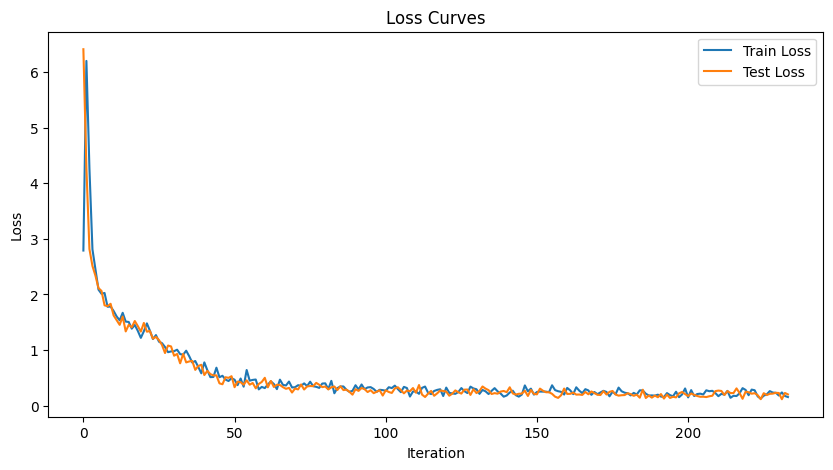

Test Set: 
    Accuracy: 94.68%


In [6]:
########### STATS ##############

def print_stats(data, targets):
    output, _ = net(data.view(data.size(0), -1))
    acc  = net.accuracy_metric(output, targets)
    #dev = np.std((targets == idx).detach().cpu().numpy()) #TODO deviation for latency encoding
    print(f"    Accuracy: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {img_counter}, Minibatch stats:")
    print(f"    Train Set Loss: {loss_hist[batch_counter]:.2f}")
    print(f"    Test Set Loss: {test_loss_hist[img_counter]:.2f}")
    print_stats(data, targets)
    print_stats(test_data, test_targets)
    print("\n")


##############################


# Load the network onto CUDA
net = Net().to(device)

loss = functional.loss.ce_rate_loss()
optimiser = torch.optim.Adam(net.parameters(),lr=lr)


num_epochs = 1
loss_hist = []
test_loss_hist = []

img_counter = 0 #total no. of images iterated over

#training loop
for epoch in range(num_epochs):
    batch_counter=0 #image number within current batch

    train_batches = iter(train_loader)

    #mini-batch loop
    for data, targets in train_batches: #torch.Size([128, 1, 28, 28]), torch.Size([128])

        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train() #inform pytorch
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        #calculate loss as cross entropy of membrane potential at each step
        loss_val = net.loss(spk_rec,targets)

        
        optimiser.zero_grad() #(reset for batch)
        loss_val.backward() #calculate backpropogation error gradient
        optimiser.step() #then update parameters

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad(): #tell pytorch to disable gradient calculation (save compute)
            net.eval()

            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = net.loss(test_spk,test_targets)
            test_loss_hist.append(test_loss.item())
            # Print train/test loss/accuracy
            if img_counter % 50 == 0:
                train_printer()
            img_counter += 1
            batch_counter +=1


###############################################################################################

# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    print("Test Set: ")
    print_stats(data,targets)

###TODO: change loss functions, latency encoding,
# can we implement STDP?

#Notes:
#training time is almost double